In [1]:
# -*- coding:utf-8
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import librosa
import soundfile
import pyaudio #录制和播放
import wave # 导入wave库，处理音频
import time
import matplotlib.pyplot as plt
from scipy.io import wavfile #读取wav提取数据
from pydub import AudioSegment #　音频处理
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用SimHei字体（可以根据需要选择其他字体）
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
def play_audio(rate,file_name): # rate 采用率 file_name保存文件名
    Chunk = 1024 # 读取的音频帧的大小
    Format = pyaudio.paInt16 #　音频格式为16位的整数
    Channels = 2 # 通道为2
    Rate = rate #采用率
    Record_times = 5 # 录制时间
    Nframes = int(Rate / Chunk * Record_times) # 计算出所需采集帧的数量
    File_name = file_name
    
    # 实例化一个对象
    p = pyaudio.PyAudio()
    
    # 使用该对象打开声卡，进入参数配置
    stream = p.open(format = Format,
                    channels = Channels,
                    rate = Rate,
                    input = True,
                    frames_per_buffer = Chunk)
    print("开始录音，整个过程持续五秒钟!!!")
    frames = []
    for i in range(0,Nframes):
        data = stream.read(Chunk)
        frames.append(data)
    print("完成录音!!!")
    
    # 关闭
    stream.stop_stream()
    stream.close()
    p.terminate()
    
    # 存储wav
    wf = wave.open(File_name,'wb') # 写入wav文件
    wf.setnchannels(Channels)# 设置通道数
    wf.setsampwidth(p.get_sample_size(Format)) # 设置样本宽度
    wf.setframerate(Rate)# 设置采样率
    wf.writeframes(b''.join(frames)) # 将列表的数据会合写入文件
    wf.close()
    print(f"语音保存为{File_name}")
    

In [9]:
play_audio(16000,"实验4.wav")

开始录音，整个过程持续五秒钟!!!
完成录音!!!
语音保存为实验4.wav


In [10]:
# 1) FrameTimeC函数实现
def FrameTimeC(frameNum, framelen, inc, fs): # inc 帧移 fs 采用频率
    frametime = np.arange(frameNum) * inc / fs + framelen / (2 * fs)
    return frametime


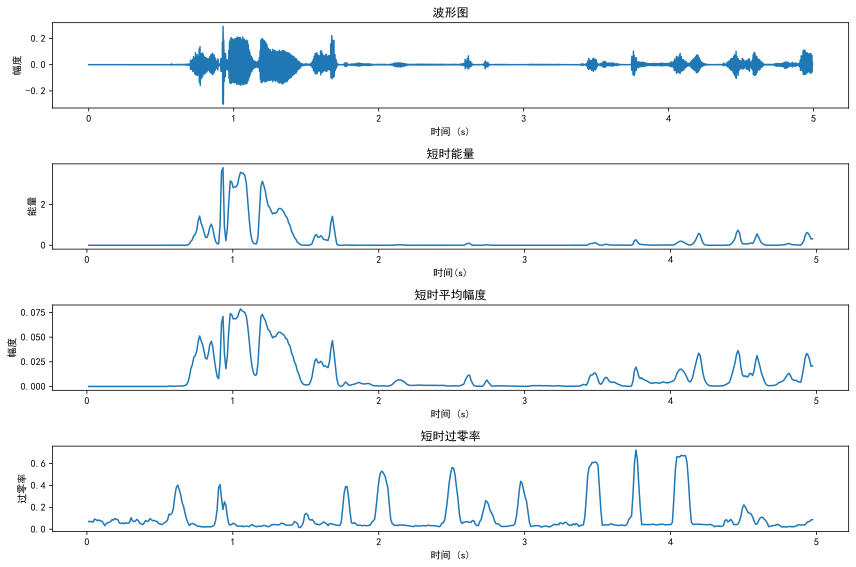

In [11]:
# 2) 短时能量、短时平均幅度和短时过零率的函数实现
def short_time_energy(x, win, inc):
    energy = []
    for i in range(0, len(x) - win + 1, inc):
        energy.append(sum(abs(x[i:i+win])**2))
    return energy

def short_time_magnitude(x, win, inc):
    magnitude = []
    for i in range(0, len(x) - win + 1, inc):
        magnitude.append(sum(abs(x[i:i+win])) / win)
    return magnitude

def short_time_zero_crossing_rate(x, win, inc):
    zero_crossing_rate = []
    for i in range(0, len(x) - win + 1, inc):
        seg = x[i:i+win]
        zero_crossing_rate.append(np.sum(seg[:-1]*seg[1:] < 0) / win)#求解平均过0率
    return zero_crossing_rate

# 加载语音文件
x, fs = librosa.load("实验4.wav", sr=None)

# 参数设置
framelen = 400  # 帧长
inc = 160  # 帧移

# 计算参数 x输入音频的信号
energy = short_time_energy(x, framelen, inc)
magnitude = short_time_magnitude(x, framelen, inc)
zero_crossing_rate = short_time_zero_crossing_rate(x, framelen, inc)

# 计算分帧后每帧对应的时间
frameNum = len(energy)
frametime = FrameTimeC(frameNum, framelen, inc, fs)

# 绘制图形
plt.figure(figsize=(12, 8))


# 计算时间轴
time = np.arange(0, len(x)) / fs

# 绘制语音波形
plt.subplot(4,1,1)
plt.plot(time, x)
plt.title('波形图')
plt.xlabel('时间 (s)')
plt.ylabel('幅度')

# 短时能量
plt.subplot(4, 1, 2)
plt.plot(frametime, energy)
plt.title('短时能量')
plt.xlabel('时间(s)')
plt.ylabel('能量')

# 短时平均幅度
plt.subplot(4, 1, 3)
plt.plot(frametime, magnitude)
plt.title('短时平均幅度')
plt.xlabel('时间 (s)')
plt.ylabel('幅度')

# 短时过零率
plt.subplot(4, 1, 4)
plt.plot(frametime, zero_crossing_rate)
plt.title('短时过零率')
plt.xlabel('时间 (s)')
plt.ylabel('过零率')

plt.tight_layout()



plt.show()



In [12]:
def short_time_autocorrelation_function(x, win, inc):
    # 初始化一个空列表，用于存储短时自相关函数（STACF）
    stacf = []
    
    # 使用窗口大小为'win'和增量为'inc'对信号'x'进行迭代
    for m in range(0, len(x) - win + 1, inc):
        # 提取当前窗口位置的信号段
        segment = x[m:m+win]
        
        # 使用np.correlate()计算信号段的自相关
        r_x_m = np.correlate(segment, segment, mode='full')[len(segment)-1:]
        
        # 以最大值作为示例，将自相关的最大值添加到stacf列表中
        stacf.append(np.max(r_x_m))  
    return stacf

def short_time_amplitude_delta_function(x, win, inc):
    # 初始化一个空列表，用于存储短时振幅变化函数（STADF）
    stadf = []
    
    # 使用窗口大小为'win'和增量为'inc'对信号'x'进行迭代
    for m in range(0, len(x) - win + 1, inc):
        # 提取当前窗口位置的信号段
        segment = x[m:m+win]
        
        # 计算信号段的振幅变化量
        delta_a_m = np.sum(np.abs(np.diff(segment)))
        
        # 将振幅变化量添加到stadf列表中
        stadf.append(delta_a_m)
    return stadf


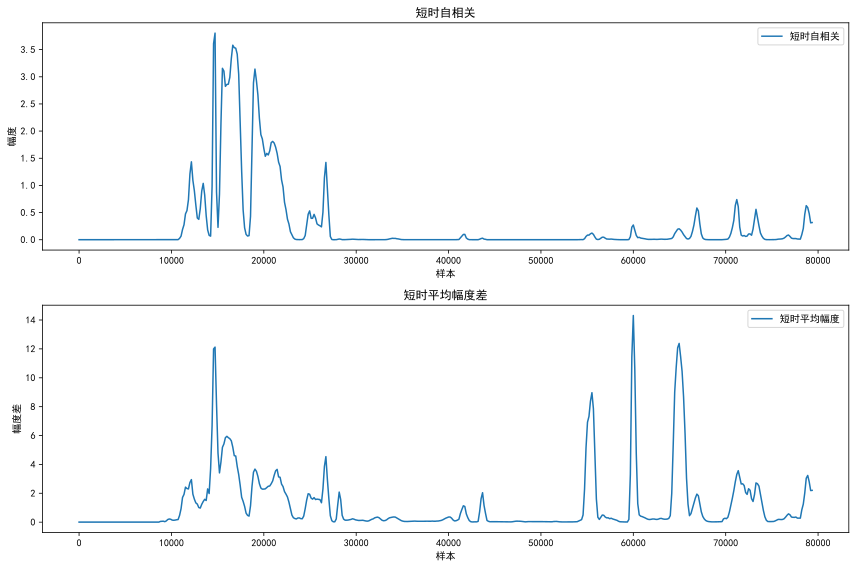

In [15]:
# 计算参数
stacf = short_time_autocorrelation_function(x, framelen, inc)
stadf= short_time_amplitude_delta_function(x, framelen, inc)

# 计算参数
stacf_result = short_time_autocorrelation_function(x, framelen, inc)
stadf_result = short_time_amplitude_delta_function(x, framelen, inc)

# 计算分帧后每帧对应的样本点数
frameNum = len(stacf_result)
samples = np.arange(0, frameNum * inc, inc)

# 绘制图形
plt.figure(figsize=(12, 8))

# 短时自相关
plt.subplot(2, 1, 1)
plt.plot(samples, stacf_result, label='短时自相关')
plt.title('短时自相关')
plt.xlabel('样本')
plt.ylabel('幅度')
plt.legend()

# 短时平均幅度差1
plt.subplot(2, 1, 2)
plt.plot(samples, stadf_result, label='短时平均幅度')
plt.title('短时平均幅度差')
plt.xlabel('样本')
plt.ylabel('幅度差')
plt.legend()

plt.tight_layout()
plt.show()

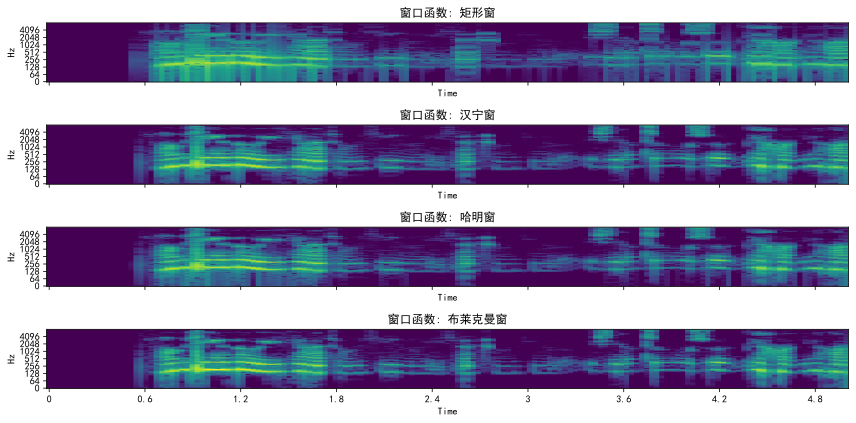

In [14]:
# 读取音频文件
file_path = '实验4.wav'
y, sr = librosa.load(file_path, sr=None)

# 定义窗函数列表
window_functions = ['rectangular', 'hann', 'hamming', 'blackman']

# 设置STFT参数
n_fft = 2048  # FFT窗口大小
hop_length = 512  # 滑动窗口的步长
# c窗函数标题
window_all = ["矩形窗","汉宁窗","哈明窗","布莱克曼窗"]
# 创建子图
fig, axes = plt.subplots(len(window_functions), 1, figsize=(12, 6), sharex=True, sharey=True)

for i, window_func in enumerate(window_functions):
    # 计算STFT
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window=window_func)),
                                 ref=np.max)

    # 绘制谱图
    librosa.display.specshow(D, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log', cmap='viridis', ax=axes[i])
    axes[i].set_title(f'窗口函数: {window_all[i]}')

plt.tight_layout()
# 显示图形
plt.show()

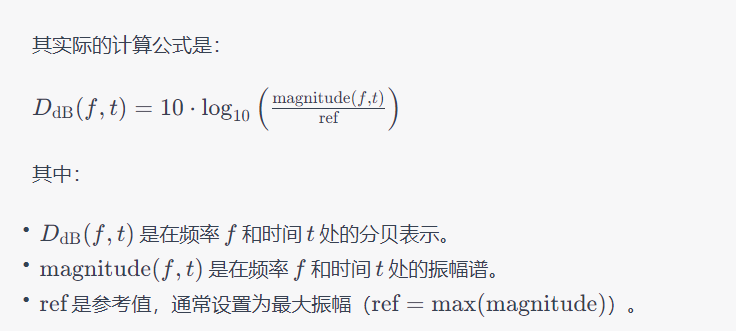